In [515]:
%matplotlib inline
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None 
import os
import datetime
from IPython.core.display import display, HTML
pd.set_option('display.max_colwidth', -1)
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/jarryxiao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


In [516]:
log_dir = "/Users/jarryxiao/poker_now_logs"
game_logs = []
for fname in os.listdir(log_dir):
    path = os.path.join(log_dir, fname)
    t = datetime.datetime.fromtimestamp(os.path.getmtime(path))
    if t.year < 2021:
        continue
    df = pd.read_csv(path)
    df["session"] = fname.split(".")[0].split("_")[-1]
    game_logs.append(df)
    
    
game = pd.concat(game_logs)
game = game.sort_values(["at", "order"]).reset_index(drop=True)

game["at"] = pd.to_datetime(game["at"])

game = game[~game.entry.str.contains("WARNING")]

game.entry = game.entry.str.replace('"', "")
game["hand_id"] = None
is_starting_hand = game.entry.str.startswith("-- starting")
starting_hands = game.loc[is_starting_hand, "entry"]
i = starting_hands.str.split(" ", expand=True)[3].str[1:].astype(int)
game.loc[is_starting_hand, "hand_id"] = i
game.hand_id = game.hand_id.ffill()

game["street"] = None
is_pre = game.entry.str.startswith("-- starting hand")
is_flop = game.entry.str.startswith("Flop")
is_turn = game.entry.str.startswith("Turn")
is_river = game.entry.str.startswith("River")
is_ending = game.entry.str.startswith("-- ending hand")
game.loc[is_pre, "street"] = "pre"
game.loc[is_flop, "street"] = "flop" 
game.loc[is_turn, "street"] = "turn" 
game.loc[is_river, "street"] = "river"
game.loc[is_ending, "street"] = "" 
game.street = game.street.ffill()

street_ids = {
    "pre": 0,
    "flop": 1,
    "turn": 2,
    "river": 3,
}
game["street_id"] = game.street.map(street_ids)

In [517]:
NUMBER_REGEX = r'(\s[0-9]+[\.]?[0-9]*(\s|$))'
has_player_info = game.entry.str.contains(" @ ")
player_subset = game.loc[has_player_info]
parsed_entry = player_subset.entry.str.split(" @ ", expand=True)
names = parsed_entry[0].str.split(expand=True).ffill(axis=1)
game.loc[has_player_info, "player"] = names[names.shape[1] - 1].str.lower()
game.loc[has_player_info, "player_id"] = parsed_entry[1].str.split(expand=True)[0]
result = game
result["folded"] = result.entry.str.endswith("folds")
result["showdown"] = result.entry.str.contains("collected") & result.entry.str.contains("with")
result["uncalled"] = result.entry.str.contains("Uncalled")
result["betting"] = 0 
is_bet = result.entry.str.contains(r"bets|posts|raises|calls")
is_payoff = result.entry.str.contains(r"collected")
result["all_in"] = result.entry.str.contains("all in")
result["bet"] = -result.entry.str.extract(NUMBER_REGEX)[0].str.strip().astype(float).round(2)
result.loc[result.folded, "bet"] = 0
result.loc[is_payoff, "bet"] *= -1
result.loc[result.uncalled, "bet"] *= -1
result.loc[is_payoff, "street"] = "result"
result.loc[result.uncalled, "street"] = "uncalled"
missed_sb = result.entry.str.contains("missing small blind")
missed_bb = result.entry.str.contains("missing big blind")
result.loc[missed_sb, "street"] = "missed_sb"
result.loc[missed_sb, "street"] = "missed_bb"
result.bet.update(result.loc[result.street == "result"].groupby(["session", "hand_id", "player"]).bet.cumsum())
result = result.merge(result.groupby(["session", "hand_id"]).showdown.any().reset_index(), on=["session", "hand_id"], suffixes=["_raw", ""])

In [518]:
aliases = dict(zip(result.player.dropna().str.lower().unique(), result.player.dropna().str.lower().unique()))
aliases["mico"] = "michael"
aliases["h"] = "matthew"
aliases["jarryx"] = "jarry"
aliases

{'h': 'matthew',
 'jarry': 'jarry',
 'matthew': 'matthew',
 'danny': 'danny',
 'hersh': 'hersh',
 'simon': 'simon',
 'aditya': 'aditya',
 'mico': 'michael',
 'jarryx': 'jarry',
 'grace': 'grace',
 'json': 'json',
 'michael': 'michael',
 'sam': 'sam'}

In [519]:
result["player"] = result["player"].map(aliases)
result["date"] = result["at"].dt.strftime("%Y-%m-%d")

pots = (
    result
    .query("bet <= 0")
    .groupby(["session", "hand_id", "street_id", "player"]).bet.last()
    .groupby(["session", "hand_id", "street_id"]).sum()
    .groupby(["session", "hand_id"]).cumsum().bfill().ffill()
    .rename("pot")
    .reset_index()
)

result = result.merge(pots, how="left", on=["session", "hand_id", "street_id"])
result["pot"] *= -1
# result["pot"] = result.pot.ffill()

In [520]:
bug_index = 8
try:
    b = bugs.loc[bug_index]
    s = b.session
    h = b.hand_id
    display(result.query("session == @s and hand_id == @h"))
    display(betting_action.query("session == @s and hand_id == @h"))
except:
    pass

In [521]:
hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
bugs = betting_action.groupby(["session", "hand_id"]).bet.sum().round(2).reset_index().query("bet != 0")
# If this DataFrame is empty, the accounting is probably correct
bugs

,session,hand_id,bet


In [523]:
result[["date", "session"]].drop_duplicates()

,date,session
0,2021-01-19,9vnH8x5uZk0B8qi3Rph0z3mTn
3262,2021-01-19,9HnLC2SEQQLlgNSRorfYR
3266,2021-01-20,9HnLC2SEQQLlgNSRorfYR
10088,2021-01-22,b0U-CTlnlVy3PzJd6we2R-yE3
18906,2021-01-25,2kN33xbxgavjQalTzbkVwY53Z
26833,2021-01-26,7wTve4gW4yQLvOuHczhcaC3Rr
34594,2021-01-27,OeYW2DkhKCS3A48mVKMfM6rhR
42545,2021-01-28,Y3onm8
50894,2021-01-30,947eqsUmJDR1n9MjNsFzm9ntI
55747,2021-01-31,lrNZIwlI8eiGaLhpUeLHlayfd


Text(0.5, 1.0, 'Total PnL')

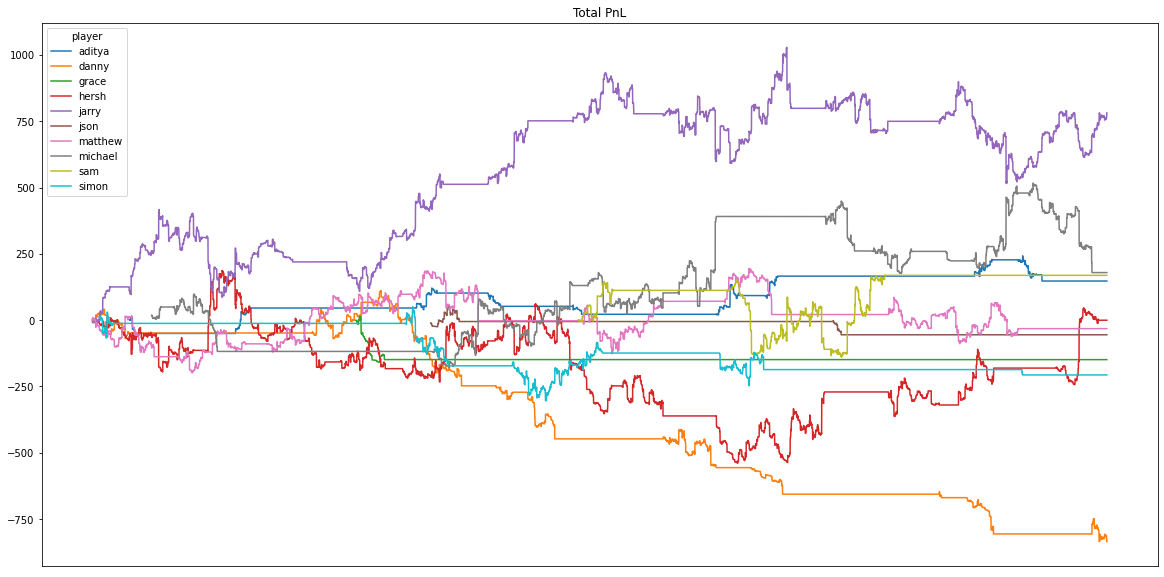

In [543]:
hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
pd.pivot_table(profits, index=["session", "hand_id"], columns="player").bet.cumsum().ffill().plot(figsize=(20, 10))
plt.xticks([])
plt.title("Total PnL")

Text(0.5, 1.0, 'Showdown PnL')

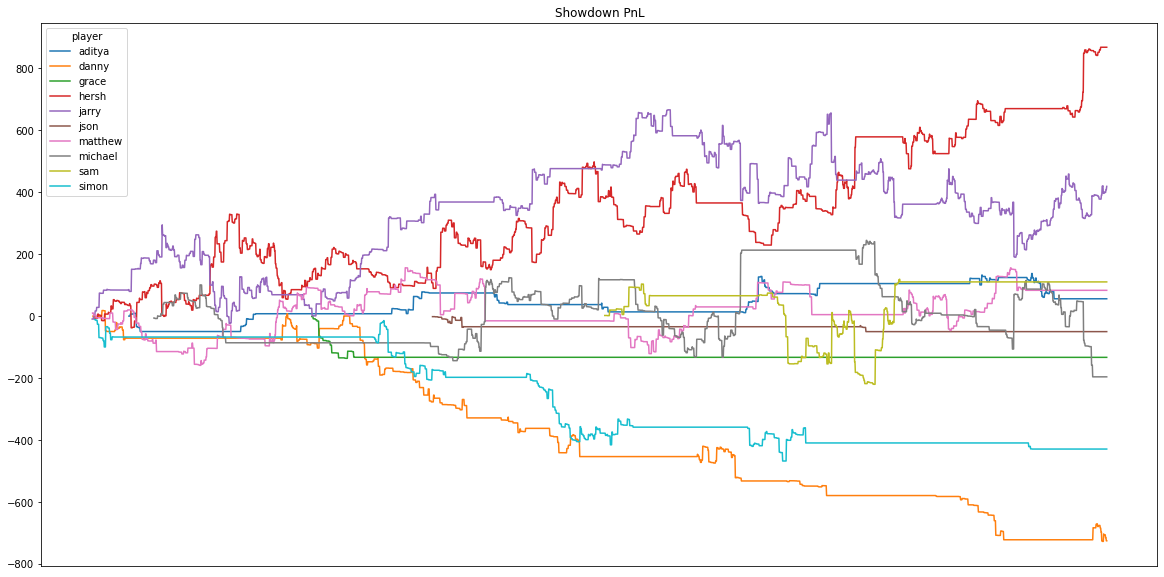

In [544]:
hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != '' and showdown")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
pd.pivot_table(profits, index=["at"], columns="player").bet.cumsum().ffill().reset_index().drop("at", axis=1).plot(figsize=(20, 10))
plt.xticks([])
plt.title("Showdown PnL")

,session,hand_id,player,bet,at
3866,9vnH8x5uZk0B8qi3Rph0z3mTn,1.0,matthew,-0.50,2021-01-19 03:03:05.687000+00:00
3865,9vnH8x5uZk0B8qi3Rph0z3mTn,1.0,jarry,0.50,2021-01-19 03:03:59.849000+00:00
3867,9vnH8x5uZk0B8qi3Rph0z3mTn,3.0,danny,-0.25,2021-01-19 03:05:17.877000+00:00
3869,9vnH8x5uZk0B8qi3Rph0z3mTn,3.0,matthew,-1.00,2021-01-19 03:05:33.191000+00:00
3868,9vnH8x5uZk0B8qi3Rph0z3mTn,3.0,jarry,1.25,2021-01-19 03:06:15.708000+00:00


Text(0.5, 1.0, 'Non-Showdown PnL')

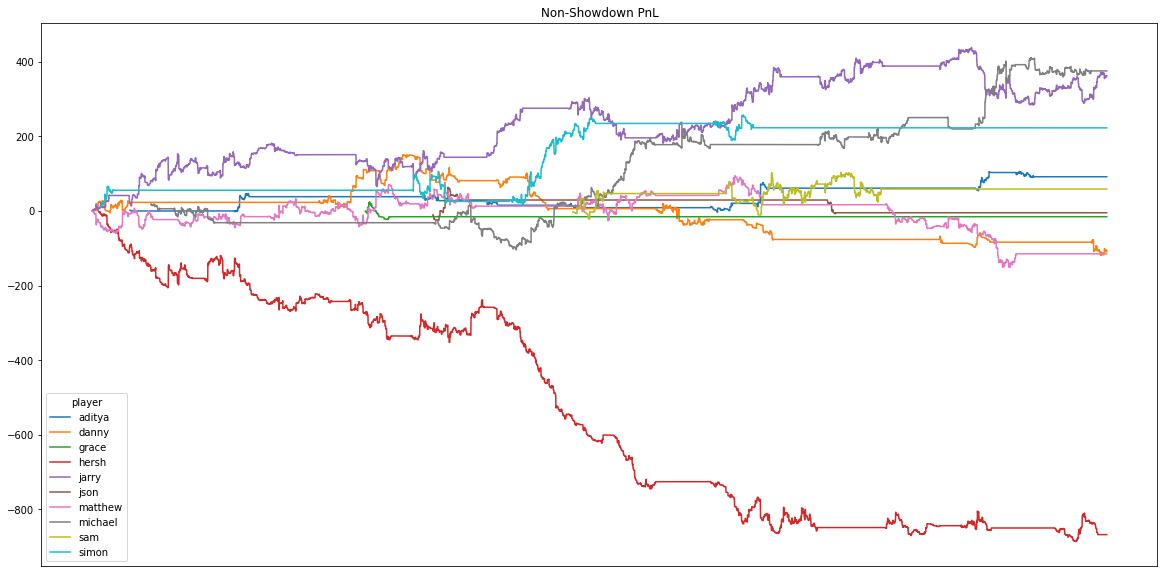

In [542]:
hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != '' and not showdown")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
display(profits.head())
pd.pivot_table(profits, index=["at"], columns="player").bet.cumsum().ffill().reset_index().drop("at", axis=1).plot(figsize=(20, 10))
plt.xticks([])
plt.title("Non-Showdown PnL")

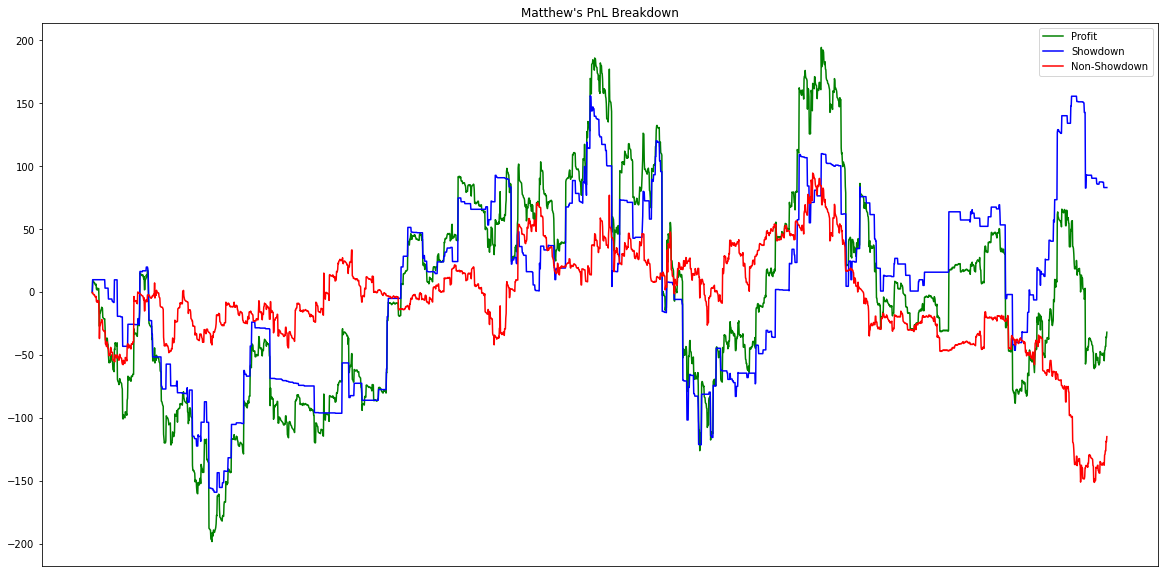

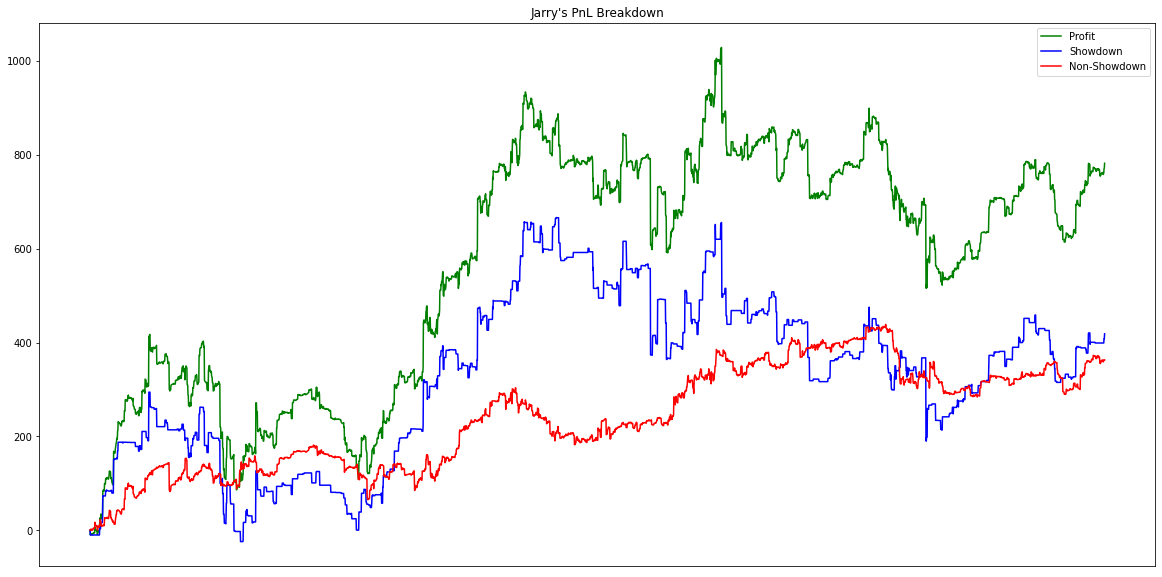

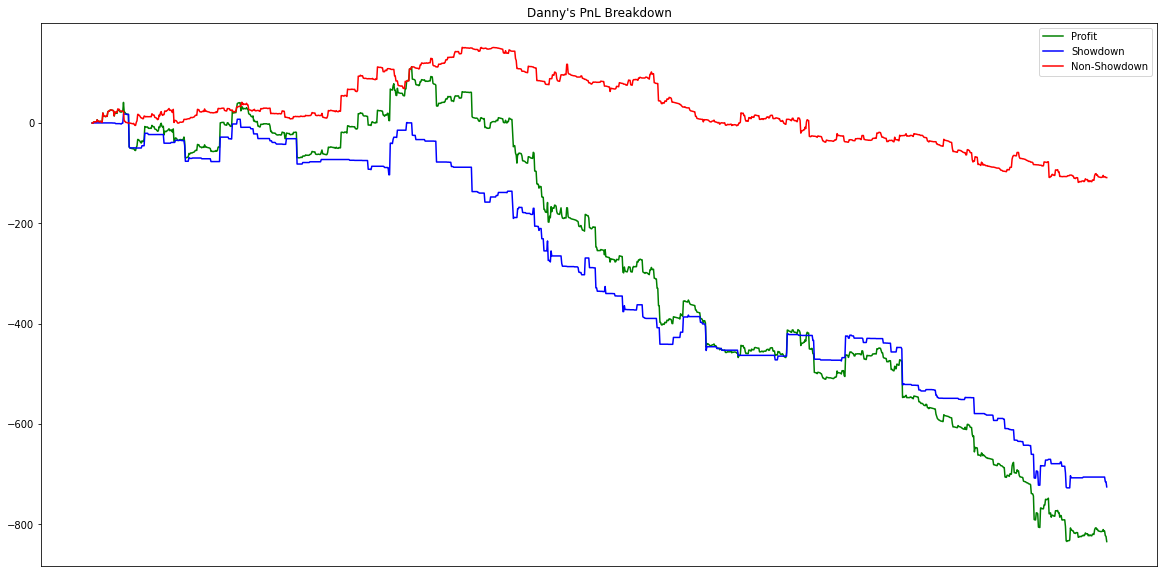

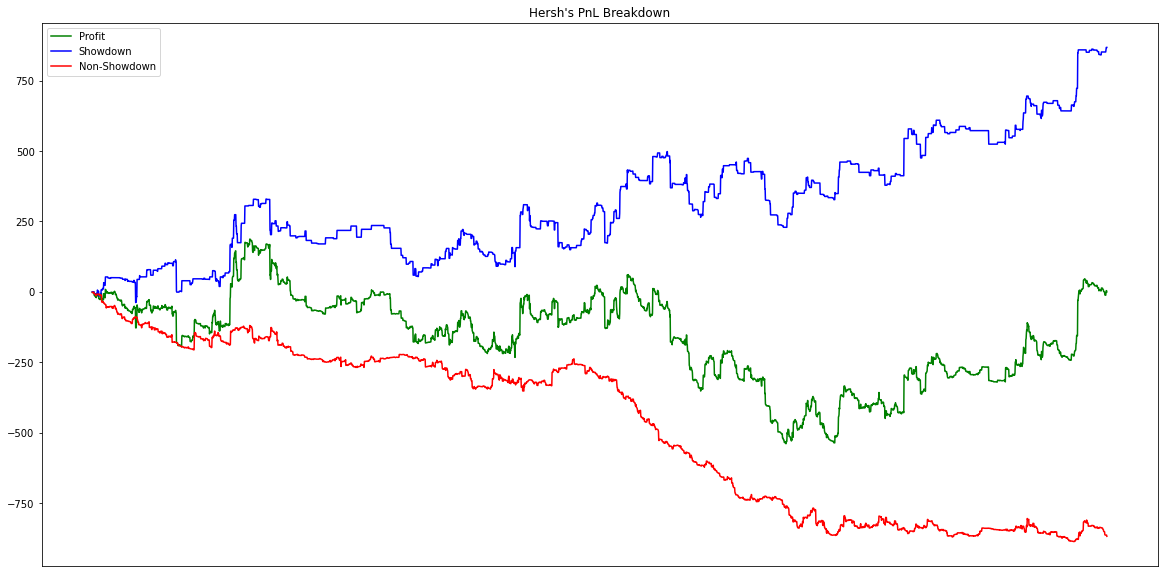

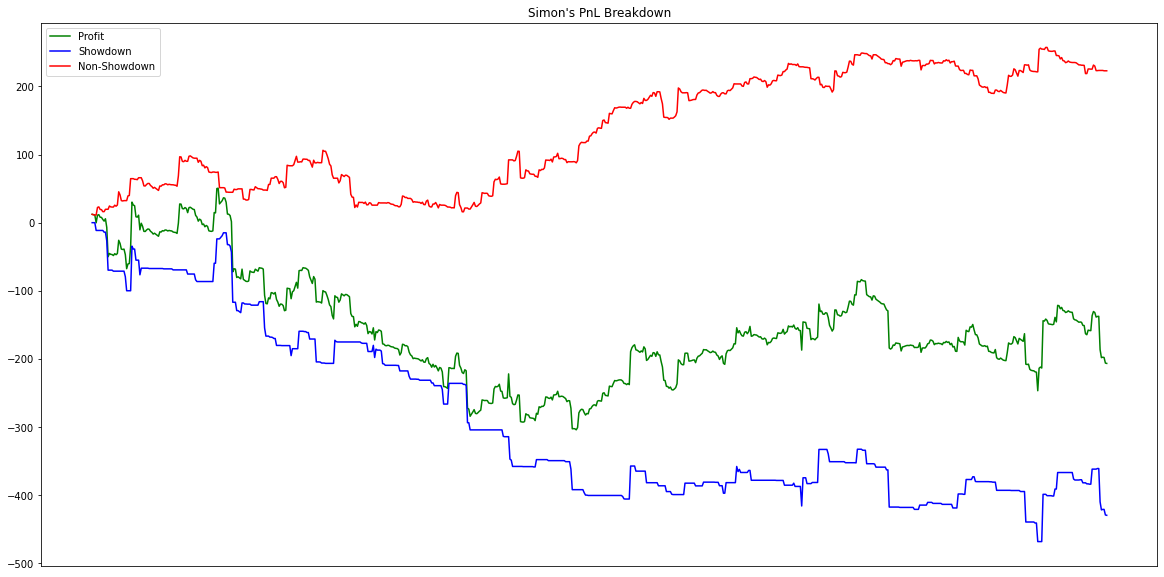

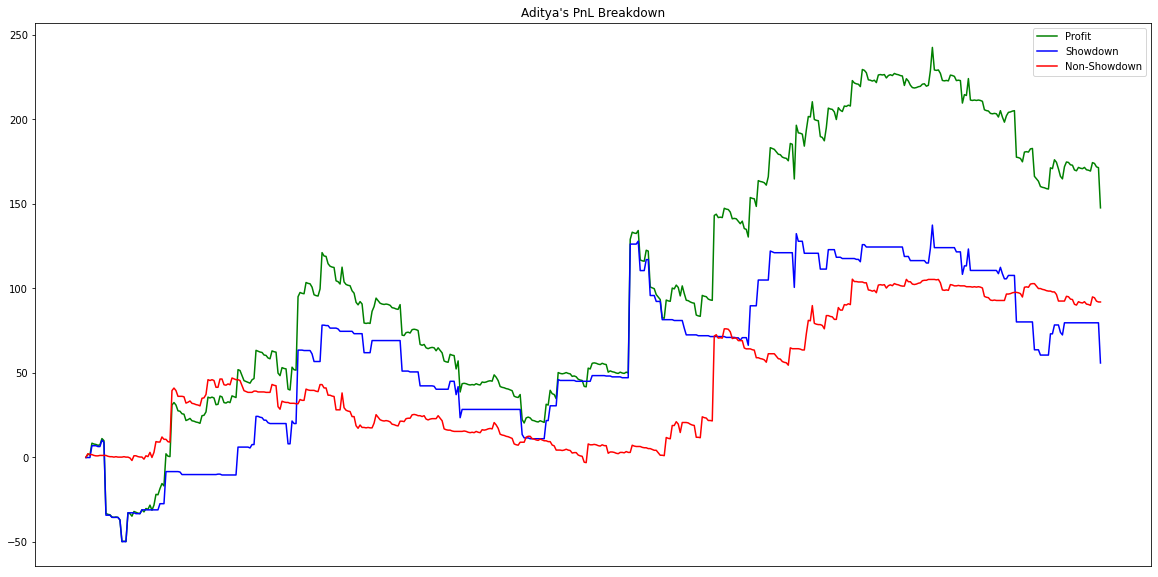

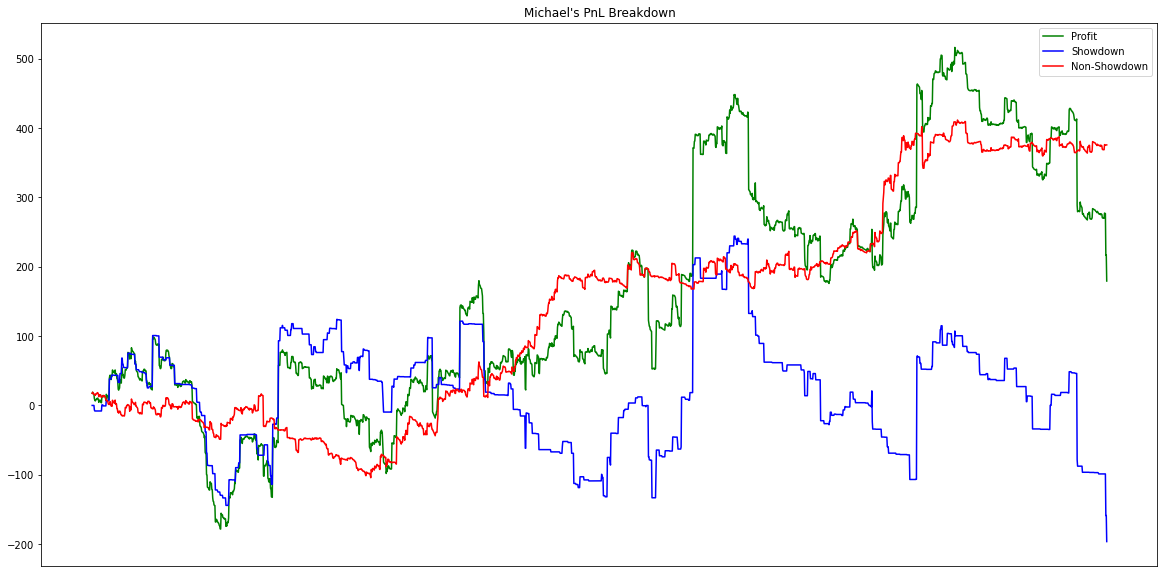

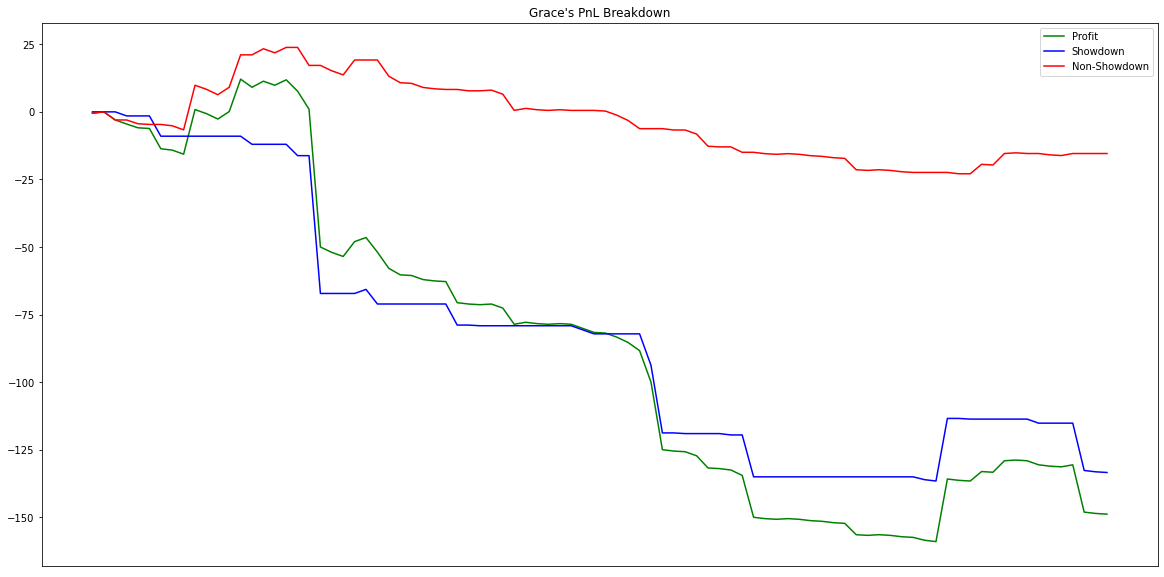

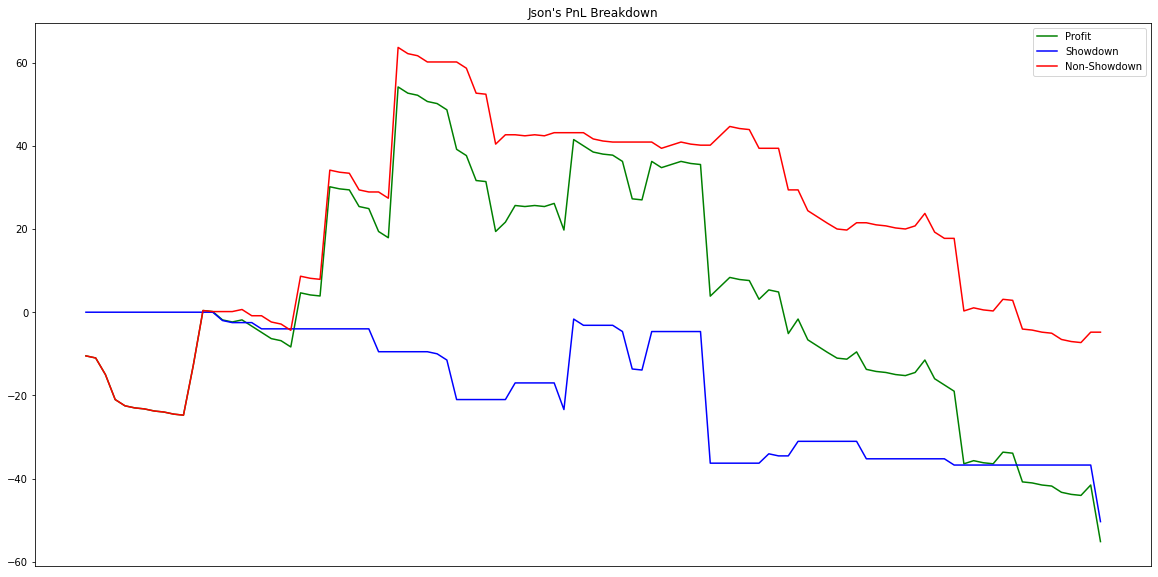

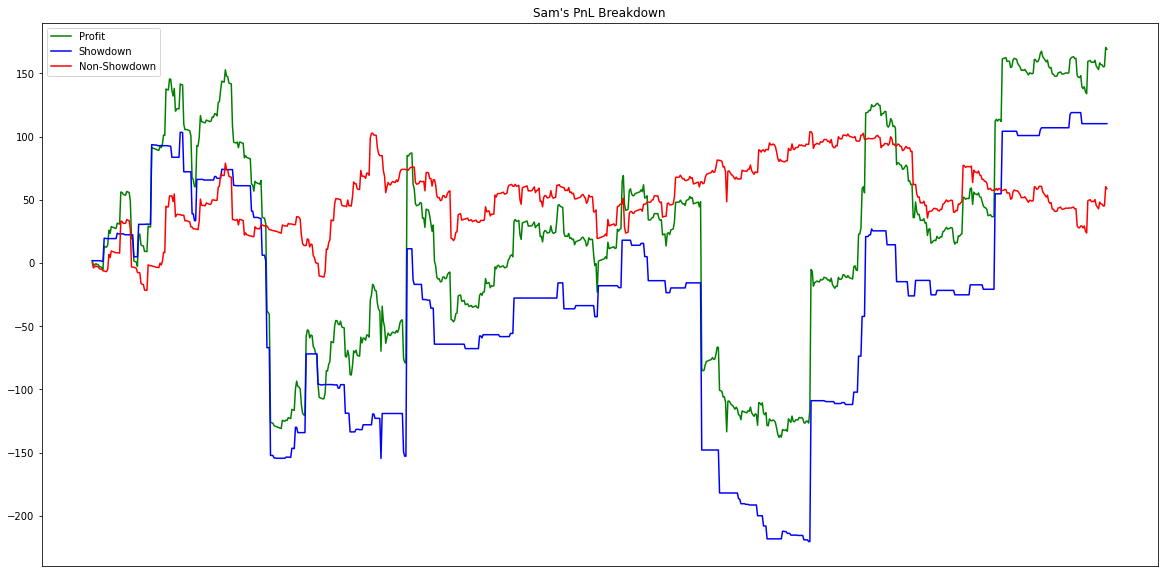

In [507]:
for player in result.player.dropna().unique():
    hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
    betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
    profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last", "showdown": "last"}).sort_values("at")

    showdown = pd.pivot_table(profits, index="at", columns="player").showdown[player].astype(float).dropna()

    total = pd.pivot_table(profits, index="at", columns="player").bet[player].dropna()
    sd = total.copy()
    nsd = total.copy()

    sd.loc[showdown == 0] = None
    sd = sd.reset_index()
    sd[player] = sd[player].cumsum().ffill().fillna(0)


    nsd.loc[showdown == 1] = None
    nsd = nsd.reset_index()
    nsd[player] = nsd[player].cumsum().ffill().fillna(0)

    total = total.reset_index()
    total[player] = total[player].cumsum().ffill().fillna(0)

    a = total.plot(y=player, color="g", figsize=(20, 10), label="Profit")
    sd.plot(y=player, color="b", ax=a, label="Showdown")
    nsd.plot(y=player, color="r", ax=a, label="Non-Showdown")
    plt.xticks([])
    plt.title(f"{player.capitalize()}'s PnL Breakdown")
    plt.show()

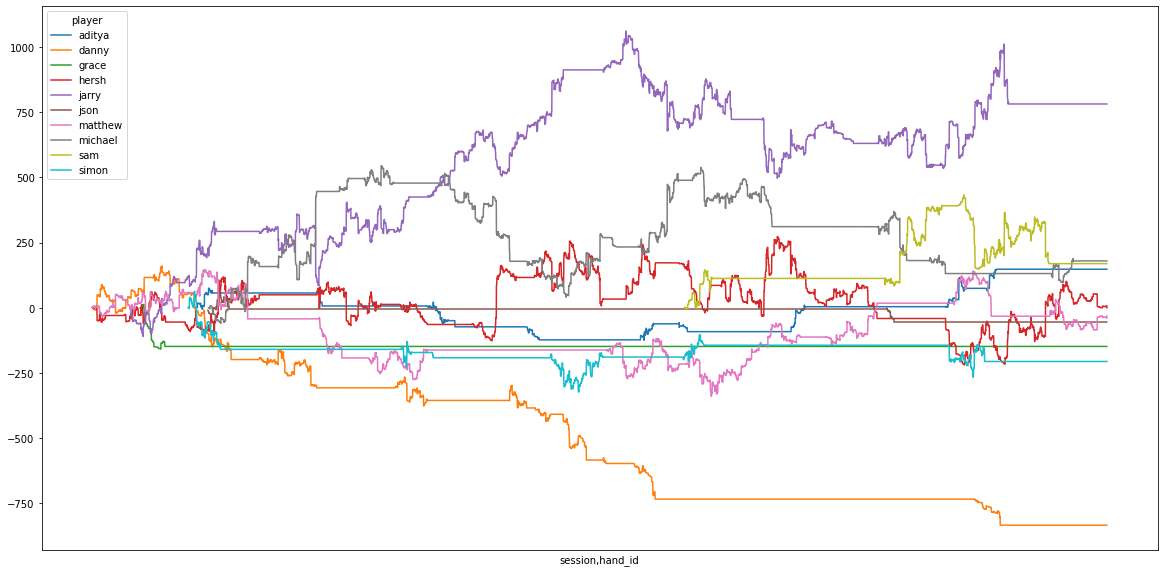

In [508]:
hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
pd.pivot_table(profits, index=["session", "hand_id"], columns="player").bet.cumsum().ffill().plot(figsize=(20, 10))
plt.xticks([])
plt.show()

In [509]:
d = "2021-02-02"
big_hands = result.query("date == @d and street == 'result' and bet >= 50")
big_hands

,entry,at,order,session,hand_id,street,street_id,player,player_id,folded,showdown_raw,uncalled,betting,all_in,bet,showdown,date,pot
66371,"jarry @ ee5k2vj8Kl collected 58.60 from pot with Pair, A's (combination: A♠, A♥, K♣, J♦, 7♠)",2021-02-02 00:10:29.643000+00:00,161222462964501,fUgYjfOwDrQ3iziVMCMeehWDl,11.0,result,3.0,jarry,ee5k2vj8Kl,False,True,False,0,False,58.60,True,2021-02-02,58.60
67018,"jarry @ ee5k2vj8Kl collected 53.82 from pot with Two Pair, K's & 2's (combination: K♥, K♦, 2♣, 2♥, 10♥)",2021-02-02 00:33:57.923000+00:00,161222603792501,fUgYjfOwDrQ3iziVMCMeehWDl,60.0,result,3.0,jarry,ee5k2vj8Kl,False,True,False,0,False,53.82,True,2021-02-02,NaN
67246,"mico @ CQ2iUAu11N collected 105.18 from pot with Straight, 5 High (combination: 5♦, 4♣, 3♠, 2♣, A♥)",2021-02-02 00:42:28.667000+00:00,161222654867300,fUgYjfOwDrQ3iziVMCMeehWDl,72.0,result,3.0,michael,CQ2iUAu11N,False,True,False,0,False,105.18,True,2021-02-02,NaN
68341,"sam @ ffxhtDI5WF collected 218.64 from pot with Pair, A's (combination: A♦, A♥, Q♠, 9♠, 8♦)",2021-02-02 01:22:13.483000+00:00,161222893348500,fUgYjfOwDrQ3iziVMCMeehWDl,139.0,result,3.0,sam,ffxhtDI5WF,False,True,False,0,False,218.64,True,2021-02-02,NaN
68678,"jarry @ ee5k2vj8Kl collected 55.10 from pot with Two Pair, J's & 10's (combination: J♠, J♦, 10♦, 10♥, Q♣)",2021-02-02 01:34:27.185000+00:00,161222966718701,fUgYjfOwDrQ3iziVMCMeehWDl,159.0,result,3.0,jarry,ee5k2vj8Kl,False,True,False,0,False,55.10,True,2021-02-02,53.60
69045,"sam @ ffxhtDI5WF collected 55.50 from pot with Two Pair, A's & 7's (combination: A♦, A♠, 7♣, 7♦, Q♥)",2021-02-02 01:46:10.269000+00:00,161223037027000,fUgYjfOwDrQ3iziVMCMeehWDl,180.0,result,3.0,sam,ffxhtDI5WF,False,True,False,0,False,55.50,True,2021-02-02,NaN
69098,"sam @ ffxhtDI5WF collected 62.80 from pot with Two Pair, A's & 10's (combination: A♣, A♠, 10♥, 10♠, 6♠)",2021-02-02 01:48:06.762000+00:00,161223048676401,fUgYjfOwDrQ3iziVMCMeehWDl,183.0,result,3.0,sam,ffxhtDI5WF,False,True,False,0,False,62.80,True,2021-02-02,62.80
69159,"sam @ ffxhtDI5WF collected 126.40 from pot with Straight, A High (combination: A♠, K♥, Q♥, J♥, 10♦)",2021-02-02 01:50:30.124000+00:00,161223063012501,fUgYjfOwDrQ3iziVMCMeehWDl,186.0,result,3.0,sam,ffxhtDI5WF,False,True,False,0,False,126.40,True,2021-02-02,126.40
69542,"jarry @ ee5k2vj8Kl collected 58.40 from pot with Two Pair, Q's & 6's (combination: Q♦, Q♥, 6♣, 6♠, J♦)",2021-02-02 02:02:43.239000+00:00,161223136324101,fUgYjfOwDrQ3iziVMCMeehWDl,212.0,result,3.0,jarry,ee5k2vj8Kl,False,True,False,0,False,58.40,True,2021-02-02,58.40
69749,jarry @ ee5k2vj8Kl collected 53.00 from pot,2021-02-02 02:06:57.129000+00:00,161223161712901,fUgYjfOwDrQ3iziVMCMeehWDl,226.0,result,1.0,jarry,ee5k2vj8Kl,False,False,False,0,False,53.00,False,2021-02-02,73.40


In [510]:
for _, row in big_hands.iterrows():
    s = row.session
    h = row.hand_id
    log = result.query("session == @s and hand_id == @h")
    display(log[["entry", "pot"]])

,entry,pot
66352,-- starting hand #11 (No Limit Texas Hold'em) (dealer: mico @ CQ2iUAu11N) --,5.6
66353,Player stacks: #1 jarry @ ee5k2vj8Kl (47.75) | #2 mico @ CQ2iUAu11N (80.40),5.6
66354,"Your hand is J♦, A♠",5.6
66355,mico @ CQ2iUAu11N posts a small blind of 0.10,5.6
66356,jarry @ ee5k2vj8Kl posts a big blind of 0.25,5.6
66357,mico @ CQ2iUAu11N raises to 1.00,5.6
66358,jarry @ ee5k2vj8Kl raises to 2.80,5.6
66359,mico @ CQ2iUAu11N calls 2.80,5.6
66360,"Flop: [7♠, 6♣, 5♠]",12.4
66361,jarry @ ee5k2vj8Kl bets 3.40,12.4


,entry,pot
66997,-- starting hand #60 (No Limit Texas Hold'em) (dealer: jarry @ ee5k2vj8Kl) --,10.00
66998,Player stacks: #1 jarry @ ee5k2vj8Kl (46.35) | #2 mico @ CQ2iUAu11N (92.05) | #3 sam @ ffxhtDI5WF (89.75),10.00
66999,"Your hand is 10♥, K♥",10.00
67000,mico @ CQ2iUAu11N posts a small blind of 0.25,10.00
67001,sam @ ffxhtDI5WF posts a big blind of 0.50,10.00
67002,The admin approved the player json @ ZVcYigdbHK participation with a stack of 50.00.,10.00
67003,jarry @ ee5k2vj8Kl raises to 1.40,10.00
67004,mico @ CQ2iUAu11N raises to 5.00,10.00
67005,sam @ ffxhtDI5WF folds,10.00
67006,jarry @ ee5k2vj8Kl calls 5.00,10.00


,entry,pot
67225,-- starting hand #72 (No Limit Texas Hold'em) (dealer: jarry @ ee5k2vj8Kl) --,10.00
67226,Player stacks: #1 jarry @ ee5k2vj8Kl (92.16) | #2 mico @ CQ2iUAu11N (52.34) | #3 sam @ ffxhtDI5WF (93.00) | #4 json @ ZVcYigdbHK (40.65),10.00
67227,"Your hand is A♠, 10♦",10.00
67228,mico @ CQ2iUAu11N posts a small blind of 0.25,10.00
67229,sam @ ffxhtDI5WF posts a big blind of 0.50,10.00
67230,json @ ZVcYigdbHK folds,10.00
67231,jarry @ ee5k2vj8Kl raises to 1.40,10.00
67232,mico @ CQ2iUAu11N raises to 5.00,10.00
67233,sam @ ffxhtDI5WF folds,10.00
67234,jarry @ ee5k2vj8Kl calls 5.00,10.00


,entry,pot
68324,-- starting hand #139 (No Limit Texas Hold'em) (dealer: sam @ ffxhtDI5WF) --,214.34
68325,Player stacks: #1 jarry @ ee5k2vj8Kl (197.82) | #2 mico @ CQ2iUAu11N (107.17) | #3 sam @ ffxhtDI5WF (168.16),214.34
68326,"Your hand is Q♣, K♥",214.34
68327,jarry @ ee5k2vj8Kl posts a small blind of 0.25,214.34
68328,mico @ CQ2iUAu11N posts a big blind of 0.50,214.34
68329,sam @ ffxhtDI5WF raises to 1.50,214.34
68330,jarry @ ee5k2vj8Kl raises to 4.30,214.34
68331,mico @ CQ2iUAu11N raises to 15.00,214.34
68332,sam @ ffxhtDI5WF raises to 35.15,214.34
68333,jarry @ ee5k2vj8Kl folds,214.34


,entry,pot
68658,-- starting hand #159 (No Limit Texas Hold'em) (dealer: sam @ ffxhtDI5WF) --,9.6
68659,Player stacks: #1 jarry @ ee5k2vj8Kl (196.89) | #2 mico @ CQ2iUAu11N (59.98) | #3 sam @ ffxhtDI5WF (266.28),9.6
68660,"Your hand is 10♦, 10♥",9.6
68661,jarry @ ee5k2vj8Kl posts a small blind of 0.25,9.6
68662,mico @ CQ2iUAu11N posts a big blind of 0.50,9.6
68663,sam @ ffxhtDI5WF raises to 1.50,9.6
68664,jarry @ ee5k2vj8Kl raises to 4.80,9.6
68665,mico @ CQ2iUAu11N calls 4.80,9.6
68666,sam @ ffxhtDI5WF folds,9.6
68667,"Flop: [J♠, J♦, Q♣]",23.6


,entry,pot
69023,-- starting hand #180 (No Limit Texas Hold'em) (dealer: sam @ ffxhtDI5WF) --,4.5
69024,Player stacks: #1 jarry @ ee5k2vj8Kl (217.22) | #2 mico @ CQ2iUAu11N (27.00) | #3 sam @ ffxhtDI5WF (278.93),4.5
69025,"Your hand is 9♥, K♣",4.5
69026,jarry @ ee5k2vj8Kl posts a small blind of 0.25,4.5
69027,mico @ CQ2iUAu11N posts a big blind of 0.50,4.5
69028,sam @ ffxhtDI5WF raises to 1.50,4.5
69029,jarry @ ee5k2vj8Kl calls 1.50,4.5
69030,mico @ CQ2iUAu11N calls 1.50,4.5
69031,"Flop: [A♠, 7♦, 6♣]",9.0
69032,jarry @ ee5k2vj8Kl checks,9.0


,entry,pot
69078,-- starting hand #183 (No Limit Texas Hold'em) (dealer: jarry @ ee5k2vj8Kl) --,9.6
69079,Player stacks: #1 jarry @ ee5k2vj8Kl (210.97) | #3 sam @ ffxhtDI5WF (312.18),9.6
69080,"Your hand is Q♥, 7♠",9.6
69081,jarry @ ee5k2vj8Kl posts a small blind of 0.25,9.6
69082,sam @ ffxhtDI5WF posts a big blind of 0.50,9.6
69083,jarry @ ee5k2vj8Kl raises to 1.40,9.6
69084,sam @ ffxhtDI5WF raises to 4.80,9.6
69085,jarry @ ee5k2vj8Kl calls 4.80,9.6
69086,"Flop: [10♥, 10♠, A♠]",28.8
69087,sam @ ffxhtDI5WF checks,28.8


,entry,pot
69139,-- starting hand #186 (No Limit Texas Hold'em) (dealer: sam @ ffxhtDI5WF) --,9.6
69140,Player stacks: #1 jarry @ ee5k2vj8Kl (182.87) | #3 sam @ ffxhtDI5WF (340.28),9.6
69141,"Your hand is A♥, K♦",9.6
69142,sam @ ffxhtDI5WF posts a small blind of 0.25,9.6
69143,jarry @ ee5k2vj8Kl posts a big blind of 0.50,9.6
69144,sam @ ffxhtDI5WF raises to 1.50,9.6
69145,jarry @ ee5k2vj8Kl raises to 4.80,9.6
69146,sam @ ffxhtDI5WF calls 4.80,9.6
69147,"Flop: [10♦, 7♣, Q♥]",37.8
69148,jarry @ ee5k2vj8Kl bets 3.00,37.8


,entry,pot
69523,-- starting hand #212 (No Limit Texas Hold'em) (dealer: sam @ ffxhtDI5WF) --,8.4
69524,Player stacks: #1 jarry @ ee5k2vj8Kl (131.32) | #3 sam @ ffxhtDI5WF (391.83),8.4
69525,"Your hand is J♦, Q♦",8.4
69526,sam @ ffxhtDI5WF posts a small blind of 0.25,8.4
69527,jarry @ ee5k2vj8Kl posts a big blind of 0.50,8.4
69528,sam @ ffxhtDI5WF raises to 1.50,8.4
69529,jarry @ ee5k2vj8Kl raises to 4.20,8.4
69530,sam @ ffxhtDI5WF calls 4.20,8.4
69531,"Flop: [Q♥, 6♣, 5♥]",18.4
69532,jarry @ ee5k2vj8Kl bets 5.00,18.4


,entry,pot
69735,-- starting hand #226 (No Limit Texas Hold'em) (dealer: sam @ ffxhtDI5WF) --,8.4
69736,Player stacks: #1 jarry @ ee5k2vj8Kl (176.07) | #3 sam @ ffxhtDI5WF (347.08),8.4
69737,"Your hand is 6♣, 5♣",8.4
69738,sam @ ffxhtDI5WF posts a small blind of 0.25,8.4
69739,jarry @ ee5k2vj8Kl posts a big blind of 0.50,8.4
69740,sam @ ffxhtDI5WF raises to 1.50,8.4
69741,jarry @ ee5k2vj8Kl raises to 4.20,8.4
69742,sam @ ffxhtDI5WF calls 4.20,8.4
69743,"Flop: [10♣, Q♣, A♣]",73.4
69744,jarry @ ee5k2vj8Kl bets 5.00,73.4


,entry,pot
70300,-- starting hand #268 (No Limit Texas Hold'em) (dealer: jarry @ ee5k2vj8Kl) --,26.0
70301,Player stacks: #1 jarry @ ee5k2vj8Kl (215.32) | #3 sam @ ffxhtDI5WF (307.83),26.0
70302,"Your hand is A♣, Q♥",26.0
70303,jarry @ ee5k2vj8Kl posts a small blind of 0.25,26.0
70304,sam @ ffxhtDI5WF posts a big blind of 0.50,26.0
70305,jarry @ ee5k2vj8Kl raises to 1.40,26.0
70306,sam @ ffxhtDI5WF raises to 4.80,26.0
70307,jarry @ ee5k2vj8Kl raises to 13.00,26.0
70308,sam @ ffxhtDI5WF calls 13.00,26.0
70309,"Flop: [J♦, K♣, 5♦]",75.0


,entry,pot
70671,-- starting hand #295 (No Limit Texas Hold'em) (dealer: sam @ ffxhtDI5WF) --,9.6
70672,Player stacks: #1 jarry @ ee5k2vj8Kl (201.57) | #3 sam @ ffxhtDI5WF (321.58),9.6
70673,"Your hand is A♦, 2♥",9.6
70674,sam @ ffxhtDI5WF posts a small blind of 0.25,9.6
70675,jarry @ ee5k2vj8Kl posts a big blind of 0.50,9.6
70676,sam @ ffxhtDI5WF raises to 1.50,9.6
70677,jarry @ ee5k2vj8Kl raises to 4.80,9.6
70678,sam @ ffxhtDI5WF calls 4.80,9.6
70679,"Flop: [3♦, A♠, 10♣]",25.0
70680,jarry @ ee5k2vj8Kl checks,25.0


,entry,pot
70759,-- starting hand #301 (No Limit Texas Hold'em) (dealer: sam @ ffxhtDI5WF) --,3.0
70760,Player stacks: #1 jarry @ ee5k2vj8Kl (126.42) | #3 sam @ ffxhtDI5WF (396.73),3.0
70761,"Your hand is K♦, 6♦",3.0
70762,sam @ ffxhtDI5WF posts a small blind of 0.25,3.0
70763,jarry @ ee5k2vj8Kl posts a big blind of 0.50,3.0
70764,sam @ ffxhtDI5WF raises to 1.50,3.0
70765,jarry @ ee5k2vj8Kl calls 1.50,3.0
70766,"Flop: [3♠, 3♣, Q♠]",9.0
70767,jarry @ ee5k2vj8Kl bets 3.00,9.0
70768,sam @ ffxhtDI5WF calls 3.00,9.0


,entry,pot
71820,-- starting hand #378 (No Limit Texas Hold'em) (dealer: mico @ CQ2iUAu11N) --,11.0
71821,Player stacks: #2 mico @ CQ2iUAu11N (69.67) | #3 sam @ ffxhtDI5WF (418.71),11.0
71822,mico @ CQ2iUAu11N posts a small blind of 0.25,11.0
71823,sam @ ffxhtDI5WF posts a big blind of 0.50,11.0
71824,mico @ CQ2iUAu11N raises to 1.50,11.0
71825,sam @ ffxhtDI5WF raises to 5.50,11.0
71826,mico @ CQ2iUAu11N calls 5.50,11.0
71827,"Flop: [Q♦, 6♣, 9♣]",86.5
71828,sam @ ffxhtDI5WF bets 9.25,86.5
71829,mico @ CQ2iUAu11N raises to 20.00,86.5


,entry,pot
72299,-- starting hand #415 (No Limit Texas Hold'em) (dealer: jarry @ ee5k2vj8Kl) --,2.80
72300,Player stacks: #1 jarry @ ee5k2vj8Kl (85.87) | #2 mico @ CQ2iUAu11N (33.45),2.80
72301,"Your hand is Q♦, 7♣",2.80
72302,jarry @ ee5k2vj8Kl posts a small blind of 0.25,2.80
72303,mico @ CQ2iUAu11N posts a big blind of 0.50,2.80
72304,jarry @ ee5k2vj8Kl raises to 1.40,2.80
72305,mico @ CQ2iUAu11N calls 1.40,2.80
72306,"Flop: [Q♣, 5♣, 7♦]",6.40
72307,mico @ CQ2iUAu11N checks,6.40
72308,jarry @ ee5k2vj8Kl bets 1.80,6.40


,entry,pot
72630,-- starting hand #24 (No Limit Texas Hold'em) (dealer: mico @ wSHy5GBoAU) --,9.0
72631,Player stacks: #1 Hersh @ o4r9ZtF2BL (51.25) | #2 matthew @ t8_z2VomPg (64.25) | #3 mico @ wSHy5GBoAU (34.50),9.0
72632,Hersh @ o4r9ZtF2BL posts a small blind of 0.25,9.0
72633,matthew @ t8_z2VomPg posts a big blind of 0.50,9.0
72634,mico @ wSHy5GBoAU raises to 1.50,9.0
72635,Hersh @ o4r9ZtF2BL raises to 4.50,9.0
72636,matthew @ t8_z2VomPg folds,9.0
72637,mico @ wSHy5GBoAU calls 4.50,9.0
72638,"Flop: [7♣, 10♠, J♣]",29.0
72639,Hersh @ o4r9ZtF2BL bets 5.00,29.0


,entry,pot
72885,-- starting hand #41 (No Limit Texas Hold'em) (dealer: Hersh @ o4r9ZtF2BL) --,9.0
72886,Player stacks: #1 Hersh @ o4r9ZtF2BL (48.70) | #2 matthew @ t8_z2VomPg (66.05) | #3 mico @ wSHy5GBoAU (76.50),9.0
72887,matthew @ t8_z2VomPg posts a small blind of 0.25,9.0
72888,mico @ wSHy5GBoAU posts a big blind of 0.50,9.0
72889,Hersh @ o4r9ZtF2BL raises to 1.50,9.0
72890,matthew @ t8_z2VomPg raises to 4.50,9.0
72891,mico @ wSHy5GBoAU folds,9.0
72892,Hersh @ o4r9ZtF2BL calls 4.50,9.0
72893,"Flop: [8♥, 8♣, 7♣]",17.0
72894,matthew @ t8_z2VomPg bets 4.00,17.0


,entry,pot
73180,-- starting hand #61 (No Limit Texas Hold'em) (dealer: mico @ wSHy5GBoAU) --,15.00
73181,Player stacks: #1 Hersh @ o4r9ZtF2BL (59.00) | #2 matthew @ t8_z2VomPg (99.30) | #3 mico @ wSHy5GBoAU (82.95),15.00
73182,Hersh @ o4r9ZtF2BL posts a small blind of 0.25,15.00
73183,matthew @ t8_z2VomPg posts a big blind of 0.50,15.00
73184,mico @ wSHy5GBoAU raises to 1.50,15.00
73185,Hersh @ o4r9ZtF2BL calls 1.50,15.00
73186,matthew @ t8_z2VomPg raises to 5.00,15.00
73187,mico @ wSHy5GBoAU calls 5.00,15.00
73188,Hersh @ o4r9ZtF2BL calls 5.00,15.00
73189,"Flop: [Q♠, 4♥, J♥]",37.00


,entry,pot
75901,-- starting hand #294 (No Limit Texas Hold'em) (dealer: Hersh @ o4r9ZtF2BL) --,96.0
75902,Player stacks: #1 Hersh @ o4r9ZtF2BL (144.82) | #2 matthew @ t8_z2VomPg (48.00),96.0
75903,Hersh @ o4r9ZtF2BL posts a small blind of 0.25,96.0
75904,matthew @ t8_z2VomPg posts a big blind of 0.50,96.0
75905,Hersh @ o4r9ZtF2BL raises to 1.50,96.0
75906,matthew @ t8_z2VomPg raises to 4.50,96.0
75907,Hersh @ o4r9ZtF2BL raises to 12.00,96.0
75908,matthew @ t8_z2VomPg raises to 48.00 and go all in,96.0
75909,Hersh @ o4r9ZtF2BL calls 48.00,96.0
75910,"Hersh @ o4r9ZtF2BL shows a Q♦, Q♥.",96.0


In [511]:
pre = result.query("bet == bet and hand_id == hand_id and street == 'pre'")

In [512]:
stats = []
for p, pg in pre.groupby("player"):
    pg = pg[
        ~pg.entry.str.contains("collect") 
        & ~pg.entry.str.contains("Uncalled")
        & ~pg.entry.str.contains("blinds")
    ]
    last_action = pg.groupby(["session", "hand_id"]).last()
    total_hands = len(last_action)
    last_action = pg.query("bet != 0").groupby(["session", "hand_id"]).last()

    calls = last_action[last_action.entry.str.contains("calls")]
    raises = last_action[last_action.entry.str.contains("bets|raises", regex=True)]
    data = {"player": p, "PFR": len(raises) / total_hands, "VPIP": (len(calls) + len(raises)) / total_hands}
    stats.append(data)
stat_df = pd.DataFrame(stats)
stat_df["PFR/VPIP"] = stat_df.eval("PFR / VPIP")
stat_df.round(2)

,player,PFR,VPIP,PFR/VPIP
0,aditya,0.10,0.38,0.28
1,danny,0.19,0.36,0.54
2,grace,0.12,0.34,0.35
3,hersh,0.26,0.49,0.53
4,jarry,0.34,0.52,0.66
5,json,0.20,0.38,0.52
6,matthew,0.29,0.40,0.73
7,michael,0.25,0.47,0.54
8,sam,0.31,0.53,0.59
9,simon,0.20,0.64,0.31
